## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.zip')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


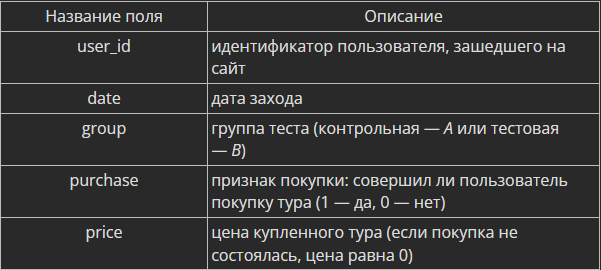

## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data['date'] = pd.to_datetime(data['date']).dt.date
data_a_first_day, data_a_last_day = data.groupby('group')['date'].min()['A'], data.groupby('group')['date'].max()['A']
data_b_first_day, data_b_last_day = data.groupby('group')['date'].min()['B'], data.groupby('group')['date'].max()['B']

print(f'Наблюдения группы A начались {data_a_first_day}, а закончились {data_a_last_day}')
print(f'Наблюдения группы B начались {data_b_first_day}, а закончились {data_b_last_day}')


Наблюдения группы A начались 2021-01-02, а закончились 2021-01-24
Наблюдения группы B начались 2021-01-02, а закончились 2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
grouped_data = data.groupby('group')[['user_id', 'purchase', 'price']].agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).rename(columns={
    'user_id': 'total_users',
    'purchase': 'purchases',
    'price': 'total_revenue'
})

total_users_a, total_users_b = grouped_data['total_users']['A'], grouped_data['total_users']['B']
total_purchases_a, total_purchases_b = grouped_data['purchases']['A'], grouped_data['purchases']['B']
total_revenue_a, total_revenue_b = grouped_data['total_revenue']['A'] / 1e6, grouped_data['total_revenue']['B'] / 1e6

print(f'Количество посещений сайта в группе А: {total_users_a}; в группе B: {total_users_b}')
print(f'Суммарное количество покупок в группе А: {total_purchases_a}; в группе В: {total_purchases_b}')
print(f'Сумма всех покупок в группе А: {total_revenue_a} млн.руб.; в группе B: {total_revenue_b} млн.руб.')

Количество посещений сайта в группе А: 147202; в группе B: 147276
Суммарное количество покупок в группе А: 17723; в группе В: 17514
Сумма всех покупок в группе А: 1436.26 млн.руб.; в группе B: 1554.1 млн.руб.


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
data_a = data[data['group'] == 'A'].copy()
data_b = data[data['group'] == 'B'].copy()
user_intersection = set(data_a['user_id']).intersection(set(data_b['user_id']))
print(f'Количество уникальных пользователей, попавших в обе группы тестирования: {len(user_intersection)}')

Количество уникальных пользователей, попавших в обе группы тестирования: 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
updated_data = data[data['user_id'].apply(lambda user: user not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

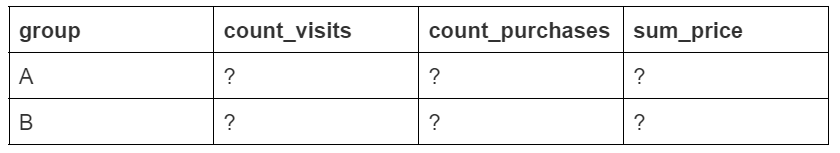
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [8]:
grouped_data = updated_data.groupby('group')[['user_id', 'purchase', 'price']].agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
})
grouped_data

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Выборки отлично сбалансированы, количество посещений и покупок приблизительно равно с небольшой погрешностью. Видим, что общая выручка выше у варианта B. Если не проводить дальнейших тестов, то на текущем этапе можно сделать вывод, что вариант В лучше, чем А. Но нам необходимо провести дополнительные исследования и проверить, действительно ли вариант B лучше. Возможно, было просто куплено больше дорогих туров(на Мальдивы, в Таиланд или на Камчатку).

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [9]:
grouped_data['conversion'] = grouped_data['count_purchases'] / grouped_data['count_visits'] * 100
grouped_data['mean_check'] = grouped_data['sum_price'] / grouped_data['count_purchases']
grouped_data

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Конверсия пользователей в группе А выше, чем в группе В, однако со средним чеком всё наоборот - B превосходит А.
Мои наблюдения на данном этапе заключаются в том, что, вероятно, тестовый вариант сайта чаще предлагает пользователям дорогие туры. Не все готовы к таким тратам и уходят с сайта, однако более платёжеспособные пользователи заинтересовываются данными предложениями и приобретают их, отсюда мы можем наблюдать такую разницу в среднем чеке и конверсии.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [10]:
pivot_table = pd.pivot_table(updated_data, values='purchase', columns='group', index='price', aggfunc='sum')
pivot_table

group,A,B
price,,
0,0,0
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

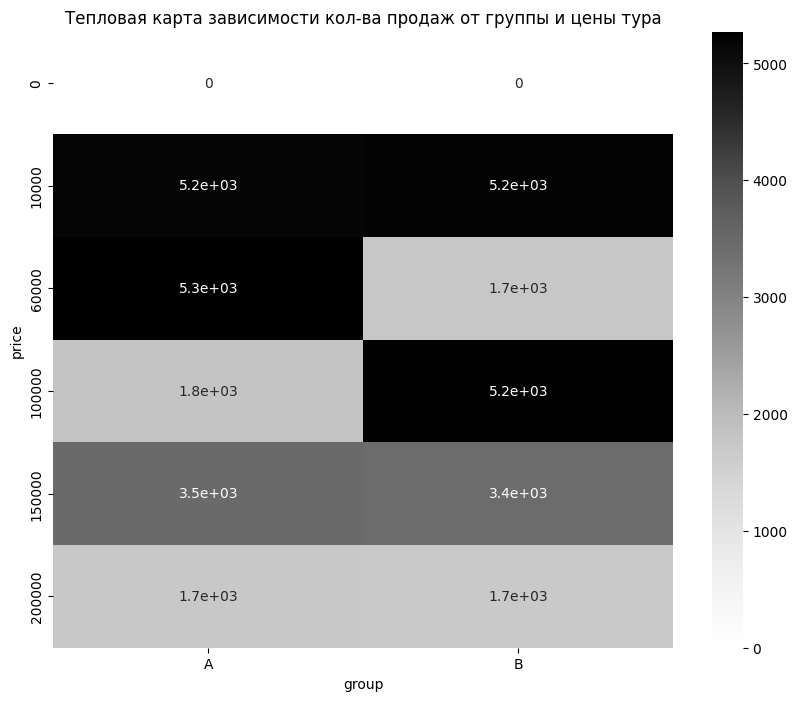

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='Greys', ax=ax)
ax.set_title('Тепловая карта зависимости кол-ва продаж от группы и цены тура');

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Из построенной тепловой карты мы видим значительную разницу в следующих показателях:
* В группе А туры стоимостью 60 000 руб.(Турция) намного популярнее, чем в группе В
* В группе В туры стоимостью 100 000 руб.(Тайланд) намного популярнее, чем в группе А

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [12]:
daily_data = updated_data.groupby(['date', 'group'])[['user_id', 'purchase', 'price']].agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'daily_users',
    'price': 'daily_revenue',
    'purchase': 'daily_purchases'
})
daily_data['daily_conversion'] = daily_data['daily_purchases'] / daily_data['daily_users'] * 100
daily_data['daily_check'] = daily_data['daily_revenue'] / daily_data['daily_purchases']
daily_data.head()

,date,group,daily_users,daily_purchases,daily_revenue,daily_conversion,daily_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [13]:
daily_data['cum_users'] = daily_data.groupby('group')['daily_users'].cumsum()
daily_data['cum_purchases'] = daily_data.groupby('group')['daily_purchases'].cumsum()
daily_data['cum_revenue'] = daily_data.groupby('group')['daily_revenue'].cumsum()
daily_data['cum_conversion'] = daily_data['cum_purchases'] / daily_data['cum_users'] * 100
daily_data['cum_check'] = daily_data['cum_revenue'] / daily_data['cum_purchases']

display(
    daily_data[daily_data['date'] == pd.Timestamp('2021-01-20').date()],
    daily_data[daily_data['date'] == pd.Timestamp('2021-01-12').date()]
)

,date,group,daily_users,daily_purchases,daily_revenue,daily_conversion,daily_check,cum_users,cum_purchases,cum_revenue,cum_conversion,cum_check
36,2021-01-20,A,6533,749,58710000,11.464871,78384.512684,121506,14561,1179590000,11.983770,81010.232814
37,2021-01-20,B,6685,790,69250000,11.817502,87658.227848,121857,14496,1286900000,11.895911,88776.214128


,date,group,daily_users,daily_purchases,daily_revenue,daily_conversion,daily_check,cum_users,cum_purchases,cum_revenue,cum_conversion,cum_check
20,2021-01-12,A,6540,795,68460000,12.155963,86113.207547,68852,8198,668070000,11.906698,81491.827275
21,2021-01-12,B,6635,807,70560000,12.162773,87434.944238,69251,8236,727670000,11.892969,88352.355512


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

In [14]:
cum_conversion_plot = px.line(
    daily_data,
    x='date',
    y='cum_conversion',
    color='group',
    title='Графики кумулятивной конверсии для групп A и B',
    width=1300,
    height=500,
    labels={
        'group': 'Группа',
        'date': 'Дата',
        'cum_conversion': 'Кумулятивная конверсия'
    }
)
cum_check_plot = px.line(
    daily_data,
    x='date',
    y='cum_check',
    color='group',
    title='Графики кумулятивного среднего чека для групп A и B',
    width=1300,
    height=500,
    labels={
        'group': 'Группа',
        'date': 'Дата',
        'cum_check': 'Кумулятивный средний чек'
    }
)
cum_conversion_plot.show()
cum_check_plot.show()

Выводу по графику кумулятивной конверсии:
* В самом начале графики нестабильны, поэтому, если бы мы не использовали кумулятивные значения, получили бы неверные результаты
* После 17.01.2021 оба графика стабилизируются почти в прямые линии, а значит теперь мы можем сравнивать разницу между тестовыми группами
* Кумулятивная конверсия у группы А больше, чем у группы В, однако, само значение этой разницы может быть слишком несущественным ($\approx 0.1\%$), поэтому в следующих заданиях мы должны выяснить с помощью тестов, является ли эта разница статистически значимой или нет.

Вывод по графику кумулятивного среднего чека:
* Хоть график в начале немного нестабилен, но общая тентедниция прослеживается на всем отрезке времени - группа В имеет более высокий кумулятивный средний чек, чем группа А. В данном случае значения отличаются на $\approx 7 тыс.руб.$ (грубые подсчеты "на глаз", сравнивая значения по графику)

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [15]:
ab_data = updated_data.groupby('group')['purchase'].agg(['count', 'sum']).rename(columns={
    'count': 'total',
    'sum': 'converted'
})
alpha = 0.05
h_0 = 'Нулевая гипотеза. Конверсии в группах равны.'
h_1 = 'Альтернативная гипотеза. Конверсия в группе А больше, чем конверсия в группе B.'

zstat, p_value = proportions_ztest(
    count=ab_data['converted'],
    nobs=ab_data['total'],
    alternative='larger' # Необходимо проверить правостороннюю гипотезу
)

display(ab_data)
print(f'P-value={p_value}')
print(h_0) if p_value > alpha else print(h_1)

,total,converted
group,,
A,145307,17487
B,145381,17290


P-value=0.11970374924914917
Нулевая гипотеза. Конверсии в группах равны.


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Результаты теста не являются статистически значимыми, мы не можем отвергать нулевую гипотезу, поэтому нет разницы между конверсиями в группах А и В.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [16]:
def proportions_conf_interval(n:int, x_p:float, gamma=0.95) -> tuple:
    
    """Calculates the confidence interval for proportion sample

    Args:
        n (int): Sample size
        x_p (float): Sample proportion(ratio)
        gamma (float, optional): Reliability level. Defaults to 0.95.

    Returns:
        tuple: Confidence interval (lower_bound, upper_bound)
    """
    
    alpha = 1 - gamma
    z_crit = abs(norm.ppf(alpha / 2))
    eps = z_crit * (x_p * (1-x_p) / n) ** 0.5
    lower_bound = x_p - eps
    upper_bound = x_p + eps
    confidence_interval = (round(lower_bound * 100, 2), round(upper_bound * 100, 2))
    return confidence_interval

a_data = updated_data[updated_data['group'] == 'A'].copy()
b_data = updated_data[updated_data['group'] == 'B'].copy()

confidence_interval_a = proportions_conf_interval(
    a_data['purchase'].count(),
    a_data['purchase'].mean()
)
confidence_interval_b = proportions_conf_interval(
    b_data['purchase'].count(),
    b_data['purchase'].mean()
)

print(f'Доверительный интервал для конверсии группы А: {confidence_interval_a}')
print(f'Доверительный интервал для конверсии группы B: {confidence_interval_b}')

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [17]:
def diff_proportions_conf_interval(n:list, x_p:list, gamma=0.95) -> tuple:
    
    """Calculates the difference between confidence intervals of two groups

    Args:
        n (list): List of 2 elements that are sample size for each group
        x_p (list): List of 2 elements that are conversions(ratio) for each group
        gamma (float, optional): Reliability level. Defaults to 0.95.

    Returns:
        tuple: Confidence interval for difference between groups (lower_bound, upper_bound)
    """
    
    alpha = 1 - gamma
    diff = x_p[1] - x_p[0]
    z_crit = abs(norm.ppf(alpha / 2))
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 
    lower_bound = diff - eps
    upper_bound = diff + eps 
    confidence_interval = round(lower_bound *100, 2), round(upper_bound * 100, 2)
    return confidence_interval

n = [a_data['purchase'].count(), b_data['purchase'].count()]
x_p = [a_data['purchase'].mean(), b_data['purchase'].mean()]
diff_interval = diff_proportions_conf_interval(n, x_p)

print('Доверительный интервал для разности конверсий:', diff_interval)

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Доверительный интервал разности конверсий охватывает точку 0, а это значит, что $ \Delta p = p_{b} - p_{a} $ может быть как положительной, так и отрицательной. Это означает, что нет разницы между конверсиями групп А и В.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [18]:
daily_data.head()

,date,group,daily_users,daily_purchases,daily_revenue,daily_conversion,daily_check,cum_users,cum_purchases,cum_revenue,cum_conversion,cum_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000,11.592827,87006.369427
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000,11.900599,81668.415530


In [19]:
h_0 = 'Нулевая гипотеза. Данные распределены нормально.'
h_1 = 'Альтернативная гипотеза. Распределение отлично от нормального.'
alpha = 0.05

stats_a, p_value_a = shapiro(daily_data[daily_data['group'] == 'A']['daily_check'])
stats_b, p_value_b = shapiro(daily_data[daily_data['group'] == 'B']['daily_check'])

display('Группа А')
print(f'P-value={p_value_a}')
print(h_0) if p_value_a > alpha else print(h_1)

display('Группа B')
print(f'P-value={p_value_b}')
print(h_0) if p_value_b > alpha else print(h_1)

'Группа А'

P-value=0.25307759642601013
Нулевая гипотеза. Данные распределены нормально.


'Группа B'

P-value=0.09378302097320557
Нулевая гипотеза. Данные распределены нормально.


В обеих группах данные по среднему чеку распределены нормально. Каждая из групп состоит из выборки в 23 элемента (продолжительность теста была 23 дня). Группы исходят из разных совокупностей. Чтобы правильно сравнить эти данные, нужно использовать независимый T-test.

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [20]:
h_0 = 'Ежедневные средние чеки в группах А и B равны'
h_1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'
alpha = 0.05
stats_a, p_value = ttest_ind(
    a=daily_data[daily_data['group'] == 'A']['daily_check'],
    b=daily_data[daily_data['group'] == 'B']['daily_check'],
    alternative='less'
)

print(f'P-value={p_value}')
print(h_0) if p_value > alpha else print(h_1)

P-value=1.1261794674808954e-12
Ежедневный средний чек в группе А меньше, чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Тест является статистически значимым, т.к. $p-value < \alpha$. Мы не можем принимать нулевую гипотезу, поэтому отвергаем её. Есть разница между ежедневными средними чеками в группах А и В, а именно - в группе А средний чек меньше, чем в группе В.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [21]:
def get_student_conf_interval(n:int, x_mean:float, x_std:float, gamma=0.95) -> tuple:
    
    """Calculates the confidence interval for the sample

    Args:
        n (int): Sample size
        x_mean (float): Sample mean
        x_std (float): Sample standard deviation
        gamma (float, optional): Reliability level. Defaults to 0.95.

    Returns:
        tuple: Confidence interval (lower_bound, upper_bound)
    """
    
    alpha = 1 - gamma
    k = n - 1
    t_crit = abs(t.ppf(alpha / 2, k))
    eps = t_crit * x_std / (n ** 0.5)
    lower_bound = x_mean - eps
    upper_bound = x_mean + eps
    confidence_interval = (round(lower_bound), round(upper_bound))
    return confidence_interval

group_a = daily_data[daily_data['group'] == 'A'].copy()
group_b = daily_data[daily_data['group'] == 'B'].copy()

sample_size_a, sample_size_b = group_a.shape[0], group_b.shape[0]
x_mean_a, x_mean_b = group_a['daily_check'].mean(), group_b['daily_check'].mean()
x_std_a, x_std_b = group_a['daily_check'].std(), group_b['daily_check'].std()

confidence_interval_a = get_student_conf_interval(sample_size_a, x_mean_a, x_std_a)
confidence_interval_b = get_student_conf_interval(sample_size_b, x_mean_b, x_std_b)

print(f'Доверительный интервал среднего чека для группы А: {confidence_interval_a}')
print(f'Доверительный интервал среднего чека для группы B: {confidence_interval_b}')

Доверительный интервал среднего чека для группы А: (79630, 82308)
Доверительный интервал среднего чека для группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Пересечения между интервалами нет, а так же мы на 95% можем быть уверены, что траты группы А лежат в диапазоне $\{79630; 82308\}$, а группы B - в диапазоне $\{87626; 89526\}$.
Тест статистически значим и группа В превосходит по тратам группу А.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Итак, про проведенному исследованию мы можем сделать 2 важных заключения:
1. Тесты разницы конверсий не имеют статистической значимости, а это означает, что наша нулевая гипотеза о том, что конверсия в группах равна, является верной с уверенностью в $95\%$.
2. Тесты разницы средних чеков статистически значимы по левосторонней альтернативной гипотезе. Это означает, что средний чек группы А меньше, чем средний чек группы В с уверенностью в $95\%$.

Исходя из этих двух заключений, мы делаем вывод, что тестовый дизайн сайта является более эффективным по среднему чеку, чем контрольный дизайн, при этом конверсия тестового дизайна не отличается от конверсии контрольного дизайна. Данный тест отвечает на вопрос "Стоит ли переходить на новую версию дизайна сайта?". Ответ - да, стоит.